# Анализ данных о квартирах на продажу в Москве

**Источник данных:** Cian.ru

**Цель:** Выполнить разведочный анализ рынка недвижимости Москвы, выявить закономерности ценообразования и создать информативные признаки для анализа.

## Этапы работы

1. Сбор данных
2. Очистка и нормализация данных
3. Анализ данных
4. Генерация признаков (Feature Engineering)
5. Выводы и рекомендации

## Импорты и инициализация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Сбор данных

Данные собираются через [Playwright](https://playwright.dev/), являющийся аналогом Selenium с расширенным набором фичей, в первую очередь связанных для async. Из-за обильного количества исполняемого JS на сайте-источнике использовать requests + BS затруднительно, поэтому выбор проводился между инструментами с полноценной поддержкой эмуляции действий пользователей. Причина выбора именно этой библиотеки тривиальна - автор сей работы знаком с ней ближе, чем с аналогами.

Сам скрейпинг осуществляется в скрипте `cian_parser.py`. Из-за низкой эффективности скрейпера количество страниц, подвергнушихся парсингу было увеличено с 3 (как в тексте задания) до 6.

## Очистка и нормализация данных

Загружаем сырые данные, удаляем дубликаты, очищаем от лишних символов и приводим к нужным типам.


In [41]:
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_clean = re.sub(r'[^0-9]', '', str(price_str))
    return float(price_clean) if price_clean else np.nan

def clean_area(area_str):
    if pd.isna(area_str):
        return np.nan
    area_clean = str(area_str).replace(',', '.')
    match = re.search(r'(\d+\.?\d*)', area_clean)
    return float(match.group(1)) if match else np.nan

def clean_number(num_str):
    if pd.isna(num_str):
        return np.nan
    match = re.search(r'(\d+)', str(num_str))
    return int(match.group(1)) if match else np.nan

def clean_text(text):
    if pd.isna(text):
        return None
    text_clean = re.sub(r'\s+', ' ', str(text))
    return text_clean.strip()

### Дропаем дубликаты (по offer_id)

In [42]:
# utf-8-sig здесь использовался для совместимости с Excel, при разведочном анализе в том числе использовал его
df_raw = pd.read_csv('data/cian_data.csv', encoding='utf-8-sig')
print(f"Загружено: {len(df_raw)} строк, {len(df_raw.columns)} столбцов")

df = df_raw.copy()

duplicates_before = len(df)
df = df.drop_duplicates(subset=['offer_id'], keep='first')
print(f"Удалено дубликатов: {duplicates_before - len(df)}")

df.head(3)

Загружено: 168 строк, 13 столбцов
Удалено дубликатов: 25


,offer_id,title,address,district,price,total_area,rooms,floor,floors_total,house_type,year_built,description,link
0,322430288,"2-комн. квартира, 90,4 м², 3/17 этаж",Москва,ЗАО,128 304 720 ₽,90.4,2.0,3.0,17.0,NaN,NaN,Продается квартира с 2-мя спальнями без отделк...,https://www.cian.ru/sale/flat/322430288/
1,323336526,Лот под ключ у Кремля,Москва,ЦАО,87 179 200 ₽,NaN,NaN,NaN,NaN,NaN,NaN,Рассрочка 0% на 12 месяцев. Lumin House - клуб...,https://www.cian.ru/sale/flat/323336526/
2,323122607,"3-комн. квартира, 111,8 м², 5/11 этаж",Москва,ЦАО,210 000 000 ₽,111.8,3.0,5.0,11.0,NaN,NaN,ХАРАКТЕРИСТИКИ КВАРТИРЫ Выполнен ремонт. ПЛАНИ...,https://www.cian.ru/sale/flat/323122607/


### Очищаем содержимое числовых полей от текста и удаляем строки с price=null/отсутствующим price

In [43]:
df['price'] = df['price'].apply(clean_price)
df['total_area'] = df['total_area'].apply(clean_area)
df['rooms'] = df['rooms'].apply(clean_number)
df['floor'] = df['floor'].apply(clean_number)
df['floors_total'] = df['floors_total'].apply(clean_number)
df['year_built'] = df['year_built'].apply(clean_number)

df['title'] = df['title'].apply(clean_text)
df['address'] = df['address'].apply(clean_text)
df['district'] = df['district'].apply(clean_text)
df['house_type'] = df['house_type'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)

rows_before = len(df)
df = df[df['price'].notna()]
print(f"Удалено строк без цены: {rows_before - len(df)}")

df = df[(df['price'] >= 1_000_000) & (df['price'] <= 5_000_000_000)]
df = df[(df['total_area'].isna()) | ((df['total_area'] >= 10) & (df['total_area'] <= 1000))]

print(f"Итого строк после очистки: {len(df)}")


Удалено строк без цены: 16
Итого строк после очистки: 127


### Сохраняем очищенные данные

In [44]:
df.to_csv('data/cian_clean.csv', index=False, encoding='utf-8')
print("Файл 'data/cian_clean.csv' создан")

print("\nПример очищенных данных:")
df[['offer_id', 'price', 'total_area', 'rooms', 'floor', 'floors_total', 'district']].head()

Файл 'data/cian_clean.csv' создан

Пример очищенных данных:


,offer_id,price,total_area,rooms,floor,floors_total,district
0,322430288,128304720.0,90.4,2.0,3.0,17.0,ЗАО
1,323336526,87179200.0,NaN,NaN,NaN,NaN,ЦАО
2,323122607,210000000.0,111.8,3.0,5.0,11.0,ЦАО
3,308803465,467910000.0,NaN,NaN,NaN,NaN,ЦАО
4,321565417,165000000.0,NaN,NaN,NaN,NaN,ЦАО


## Анализ данных

### Описание набора данных


In [45]:
print(f"Количество строк: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")
print(f"\nТипы данных:\n{df.dtypes}")

print("\nПропуски в данных:")
missing = df.isnull().sum()
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Пропусков': missing, 'Процент': missing_percent})
missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

Количество строк: 127
Количество столбцов: 13

Типы данных:
offer_id          int64
title            object
address          object
district         object
price           float64
total_area      float64
rooms           float64
floor           float64
floors_total    float64
house_type       object
year_built      float64
description      object
link             object
dtype: object

Пропуски в данных:


,Пропусков,Процент
house_type,127,100.00
year_built,127,100.00
total_area,89,70.08
floor,89,70.08
floors_total,89,70.08
rooms,85,66.93
description,5,3.94


### Базовая статистика


In [46]:
df[['price', 'total_area', 'rooms', 'floor', 'floors_total', 'year_built']].describe()

,price,total_area,rooms,floor,floors_total,year_built
count,1.270000e+02,38.000000,42.000000,38.000000,38.000000,0.0
mean,1.792658e+08,123.885526,2.619048,7.052632,17.947368,NaN
std,2.150637e+08,89.274726,1.447494,7.399589,17.424660,NaN
min,1.237640e+07,26.870000,0.000000,2.000000,4.000000,NaN
25%,5.241575e+07,66.600000,2.000000,2.000000,7.250000,NaN
50%,9.900000e+07,106.100000,3.000000,4.500000,12.000000,NaN
75%,2.108400e+08,141.350000,3.750000,7.000000,21.000000,NaN
max,1.297600e+09,405.500000,6.000000,38.000000,90.000000,NaN


### Распределение цен

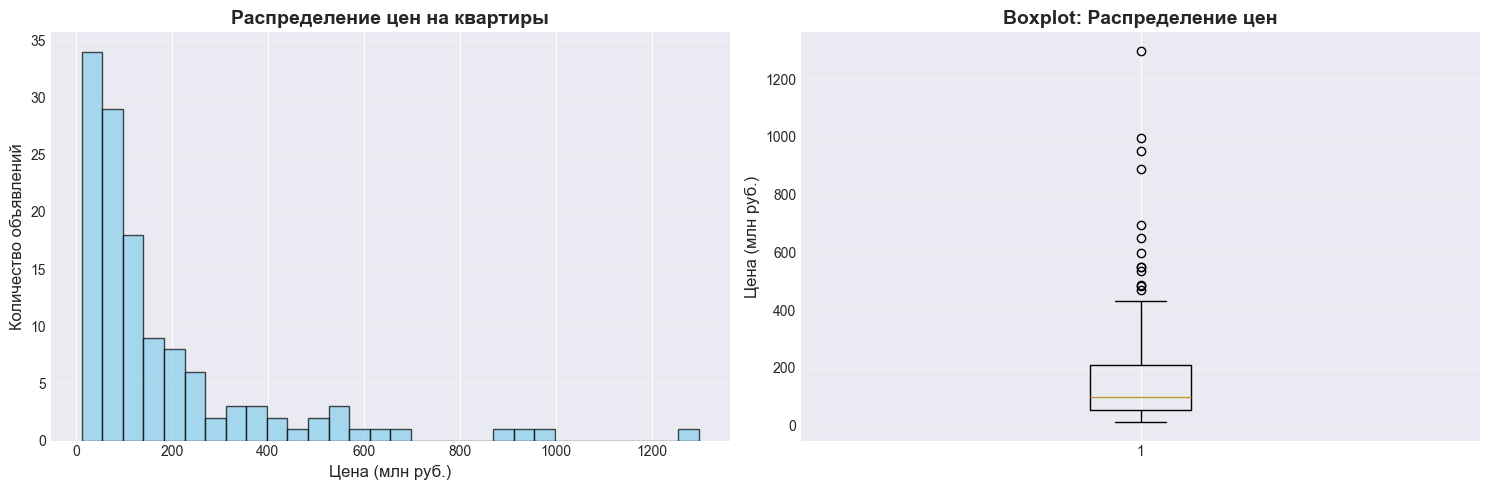

Средняя цена: 179.27 млн руб.
Медианная цена: 99.00 млн руб.
Минимальная цена: 12.38 млн руб.
Максимальная цена: 1297.60 млн руб.


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['price'] / 1_000_000, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Цена (млн руб.)', fontsize=12)
axes[0].set_ylabel('Количество объявлений', fontsize=12)
axes[0].set_title('Распределение цен на квартиры', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].boxplot(df['price'] / 1_000_000, vert=True)
axes[1].set_ylabel('Цена (млн руб.)', fontsize=12)
axes[1].set_title('Boxplot: Распределение цен', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('images/price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Средняя цена: {df['price'].mean() / 1_000_000:.2f} млн руб.")
print(f"Медианная цена: {df['price'].median() / 1_000_000:.2f} млн руб.")
print(f"Минимальная цена: {df['price'].min() / 1_000_000:.2f} млн руб.")
print(f"Максимальная цена: {df['price'].max() / 1_000_000:.2f} млн руб.")

### Зависимость цены от площади

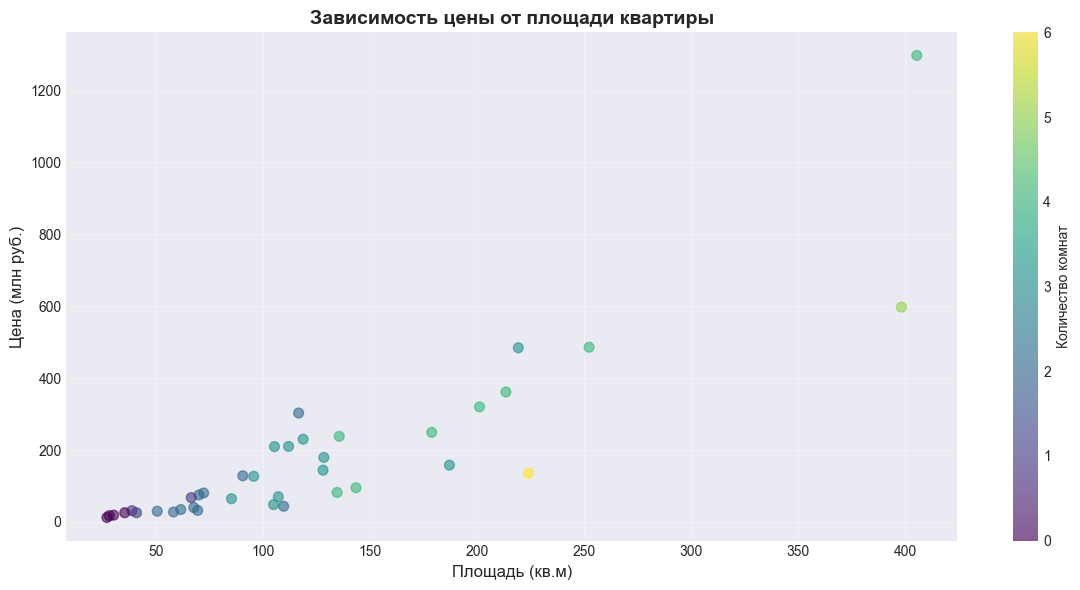

Корреляция между ценой и площадью: 0.873


In [48]:
df_area = df[df['total_area'].notna()]

if len(df_area) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    scatter = ax.scatter(df_area['total_area'], df_area['price'] / 1_000_000, 
                         alpha=0.6, c=df_area['rooms'], cmap='viridis', s=50)
    ax.set_xlabel('Площадь (кв.м)', fontsize=12)
    ax.set_ylabel('Цена (млн руб.)', fontsize=12)
    ax.set_title('Зависимость цены от площади квартиры', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Количество комнат', fontsize=10)
    plt.tight_layout()
    plt.savefig('images/price_vs_area.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    correlation = df_area['price'].corr(df_area['total_area'])
    print(f"Корреляция между ценой и площадью: {correlation:.3f}")

### Анализ по районам


In [49]:
df_district = df[df['district'].notna()]

if len(df_district) > 0:
    district_stats = df_district.groupby('district').agg({
        'price': ['mean', 'median', 'count']
    }).round(2)
    district_stats.columns = ['Средняя цена', 'Медианная цена', 'Количество']
    district_stats = district_stats[district_stats['Количество'] >= 2]
    district_stats = district_stats.sort_values('Средняя цена', ascending=False)
    
    print("ТОП-5 самых дорогих районов:")
    print(district_stats.head())

ТОП-5 самых дорогих районов:
          Средняя цена  Медианная цена  Количество
district                                          
ЦАО       2.433731e+08     136750000.0          80
ЗАО       1.078640e+08      91000000.0          22
СЗАО      5.563770e+07      48208524.0           5
ЮЗАО      4.232781e+07      31254620.0           3
ЮАО       3.626399e+07      27669840.5           4


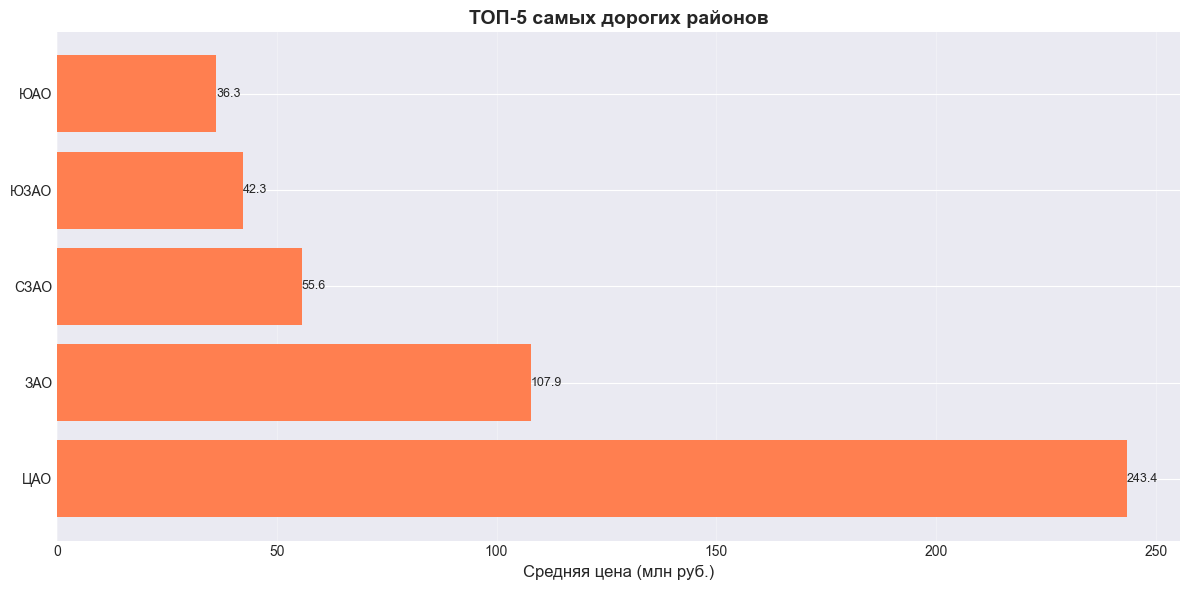

In [50]:
if len(df_district) > 0 and len(district_stats) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_districts = district_stats.head(5)
    bars = ax.barh(range(len(top_districts)), top_districts['Средняя цена'] / 1_000_000, color='coral')
    ax.set_yticks(range(len(top_districts)))
    ax.set_yticklabels(top_districts.index)
    ax.set_xlabel('Средняя цена (млн руб.)', fontsize=12)
    ax.set_title('ТОП-5 самых дорогих районов', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('images/price_by_district.png', dpi=300, bbox_inches='tight')
    plt.show()


### Цена за квадратный метр


In [51]:
df_with_area = df[(df['total_area'].notna()) & (df['total_area'] > 0)].copy()
df_with_area['price_per_m2'] = df_with_area['price'] / df_with_area['total_area']

if len(df_with_area) > 0:
    print(f"Средняя цена за кв.м: {df_with_area['price_per_m2'].mean():,.0f} руб.")
    print(f"Медианная цена за кв.м: {df_with_area['price_per_m2'].median():,.0f} руб.")

Средняя цена за кв.м: 1,150,659 руб.
Медианная цена за кв.м: 932,444 руб.


### Количество комнат


In [52]:
df_rooms = df[df['rooms'].notna()]

if len(df_rooms) > 0:
    rooms_stats = df_rooms.groupby('rooms').agg({
        'price': ['mean', 'median', 'count'],
        'total_area': 'mean'
    }).round(2)
    rooms_stats.columns = ['Средняя цена', 'Медианная цена', 'Количество', 'Средняя площадь']
    print("Статистика по количеству комнат:")
    print(rooms_stats)

Статистика по количеству комнат:
       Средняя цена  Медианная цена  Количество  Средняя площадь
rooms                                                           
0.0    1.777365e+07      17484400.0           5            30.02
1.0    4.153352e+07      31304600.0           3            48.53
2.0    7.944033e+07      41793763.5          10            76.50
3.0    1.554011e+08     144000000.0          13           126.40
4.0    3.911430e+08     284554760.5           8           208.04
5.0    5.665800e+08     566580000.0           2           398.30
6.0    1.350000e+08     135000000.0           1           224.00


## Генерация признаков (Feature Engineering)

In [53]:
df_features = df.copy()
current_year = 2025

df_features['price_per_m2'] = np.where(
    df_features['total_area'].notna() & (df_features['total_area'] > 0),
    df_features['price'] / df_features['total_area'],
    np.nan
)

df_features['is_new_building'] = np.where(df_features['year_built'] >= 2010, 1, 0)

df_features['building_age'] = np.where(
    df_features['year_built'].notna(),
    current_year - df_features['year_built'],
    np.nan
)

df_features['floor_ratio'] = np.where(
    (df_features['floor'].notna()) & (df_features['floors_total'].notna()) & (df_features['floors_total'] > 0),
    df_features['floor'] / df_features['floors_total'],
    np.nan
)

def categorize_floor(row):
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return 'unknown'
    elif row['floor'] == 1:
        return 'first'
    elif row['floor'] == row['floors_total']:
        return 'last'
    else:
        return 'middle'

df_features['floor_category'] = df_features.apply(categorize_floor, axis=1)

def categorize_area(area):
    if pd.isna(area):
        return 'unknown'
    elif area < 40:
        return 'small'
    elif area < 80:
        return 'medium'
    elif area < 120:
        return 'large'
    else:
        return 'xlarge'

df_features['area_category'] = df_features['total_area'].apply(categorize_area)

def categorize_price(price):
    if pd.isna(price):
        return 'unknown'
    elif price < 30_000_000:
        return 'budget'
    elif price < 100_000_000:
        return 'medium'
    elif price < 300_000_000:
        return 'premium'
    else:
        return 'luxury'

df_features['price_category'] = df_features['price'].apply(categorize_price)

print("Созданные признаки:")
print("1. price_per_m2 - цена за квадратный метр")
print("2. is_new_building - признак новостройки (1/0)")
print("3. building_age - возраст здания в годах")
print("4. floor_ratio - отношение этажа к общему количеству")
print("5. floor_category - категория этажа (first/middle/last)")
print("6. area_category - категория площади (small/medium/large/xlarge)")
print("7. price_category - категория цены (budget/medium/premium/luxury)")

Созданные признаки:
1. price_per_m2 - цена за квадратный метр
2. is_new_building - признак новостройки (1/0)
3. building_age - возраст здания в годах
4. floor_ratio - отношение этажа к общему количеству
5. floor_category - категория этажа (first/middle/last)
6. area_category - категория площади (small/medium/large/xlarge)
7. price_category - категория цены (budget/medium/premium/luxury)


In [54]:
print("Распределение по категориям цен:")
print(df_features['price_category'].value_counts())

if df_features['year_built'].notna().sum() > 0:
    print("\nНовостройки vs Старые дома:")
    building_comparison = df_features.groupby('is_new_building').agg({
        'price': 'mean',
        'price_per_m2': 'mean',
        'offer_id': 'count'
    }).round(2)
    building_comparison.index = ['Старые дома', 'Новостройки']
    building_comparison.columns = ['Средняя цена', 'Цена за кв.м', 'Количество']
    print(building_comparison)

print("\nСредняя цена по категориям этажей:")
floor_cat_price = df_features.groupby('floor_category')['price'].agg(['mean', 'count']).round(2)
floor_cat_price.columns = ['Средняя цена', 'Количество']
print(floor_cat_price)

Распределение по категориям цен:
price_category
medium     50
premium    41
luxury     22
budget     14
Name: count, dtype: int64

Средняя цена по категориям этажей:
                Средняя цена  Количество
floor_category                          
last            4.587250e+08           2
middle          1.628459e+08          36
unknown         1.796275e+08          89


### Сохранение данных с признаками


In [55]:
df_features.to_csv('data/cian_features.csv', index=False, encoding='utf-8-sig')
print("Файл 'data/cian_features.csv' создан")

Файл 'data/cian_features.csv' создан


## Выводы

### Сводная таблица показателей


In [56]:
summary_data = {
    'Показатель': [
        'Всего объявлений',
        'Средняя цена (млн руб.)',
        'Медианная цена (млн руб.)',
        'Средняя площадь (кв.м)',
        'Средняя цена за кв.м (руб.)',
        'Среднее количество комнат',
        'Средняя этажность зданий',
    ],
    'Значение': [
        len(df_features),
        f"{df_features['price'].mean() / 1_000_000:.2f}",
        f"{df_features['price'].median() / 1_000_000:.2f}",
        f"{df_features['total_area'].mean():.1f}" if df_features['total_area'].notna().any() else 'N/A',
        f"{df_features['price_per_m2'].mean():,.0f}" if df_features['price_per_m2'].notna().any() else 'N/A',
        f"{df_features['rooms'].mean():.1f}" if df_features['rooms'].notna().any() else 'N/A',
        f"{df_features['floors_total'].mean():.1f}" if df_features['floors_total'].notna().any() else 'N/A',
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Показатель,Значение
0,Всего объявлений,127
1,Средняя цена (млн руб.),179.27
2,Медианная цена (млн руб.),99.00
3,Средняя площадь (кв.м),123.9
4,Средняя цена за кв.м (руб.),"1,150,659"
5,Среднее количество комнат,2.6
6,Средняя этажность зданий,17.9


### Основные выводы


In [58]:
if 'district_stats' in locals() and len(district_stats) > 0:
    print("САМЫЕ ДОРОГИЕ РАЙОНЫ:")
    for idx, (district, row) in enumerate(district_stats.head(3).iterrows(), 1):
        print(f"   {idx}. {district}: {row['Средняя цена'] / 1_000_000:.1f} млн руб.")

if 'correlation' in locals():
    print(f"\nЗАВИСИМОСТЬ ЦЕНЫ ОТ ПЛОЩАДИ:")
    print(f"   Корреляция: {correlation:.3f}")
    if correlation > 0.7:
        print("   Сильная корреляция - цена растет с увеличением площади")
    elif correlation > 0.4:
        print("   Умеренная корреляция - площадь влияет на цену, но не единственный фактор")

if df_features['rooms'].notna().any():
    popular_rooms = df_features['rooms'].value_counts().head(3)
    print(f"\nПОПУЛЯРНЫЕ ТИПЫ КВАРТИР:")
    for rooms, count in popular_rooms.items():
        room_text = "студия" if rooms == 0 else f"{int(rooms)}-комнатные"
        print(f"   {room_text}: {count} объявлений ({count/len(df_features)*100:.1f}%)")

print(
"""
Московский рынок недвижимости демонстрирует значительный разброс цен в зависимости от района, площади и других характеристик.
Самые дорогие районы - престижные центральные районы. 
Цена в значительной степени коррелирует с площадью квартиры.
"""
)

САМЫЕ ДОРОГИЕ РАЙОНЫ:
   1. ЦАО: 243.4 млн руб.
   2. ЗАО: 107.9 млн руб.
   3. СЗАО: 55.6 млн руб.

ЗАВИСИМОСТЬ ЦЕНЫ ОТ ПЛОЩАДИ:
   Корреляция: 0.873
   Сильная корреляция - цена растет с увеличением площади

ПОПУЛЯРНЫЕ ТИПЫ КВАРТИР:
   3-комнатные: 13 объявлений (10.2%)
   2-комнатные: 10 объявлений (7.9%)
   4-комнатные: 8 объявлений (6.3%)

Московский рынок недвижимости демонстрирует значительный разброс цен в зависимости от района, площади и других характеристик.
Самые дорогие районы - престижные центральные районы. 
Цена в значительной степени коррелирует с площадью квартиры.

